
### _Enhancing Sentiment Classification on Small Datasets through Data Augmentation and Transfer Learning: A Comparative Study_

##Notebook Description:

__The Objective:__ This notebook supports the study _"Enhancing Sentiment Classification on Small Datasets through Data Augmentation and Transfer Learning"_. It explores the impact of data augmentation techniques: __Easy Data Augmentation (EDA)__, __NLPaug__ and __Back-Translation__ on sentiment classification performance. Classical machine learning models, including __Logistic Regression__ and __Random Forest__, are trained on both the original and augmented datasets. Additionally, a __BERT__ model is fine-tuned on the original dataset and again on a dataset augmented using NLPaug, leveraging transfer learning. Model performance is evaluated using metrics such as Accuracy, F1-score, and AUC.

## Authors:
### _Mahmoud Mayaleh_ & _Samer Mayaleh_

## Step 1: Installing dependencies

In [ ]:
!pip install scikit-learn pandas torch transformers
!pip install -q nlpaug
!pip install googletrans==4.0.0-rc1
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

__Importing Librarys:__

In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
import nlpaug.augmenter.word as naw
import random
import os
import zipfile
import nltk
import random
import re
from googletrans import Translator
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
import numpy as np
import random
import time
from scipy import stats
from scipy.stats import t
from scipy.optimize import minimize_scalar
from torch import amp, cuda
from io import StringIO

## Step 2: Dataset preparation

__Importing Data:__

In [ ]:
dataset = load_dataset("imdb", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame(dataset)

In [ ]:
# Sample 5000 entries to simulate a small dataset
df_small = df.sample(n=5000, random_state=42)[['text', 'label']]
df_small = df_small.rename(columns={'text': 'review'})

In [ ]:
#shuffling data
df_small = shuffle(df_small, random_state=42).reset_index(drop=True)

In [ ]:
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(df_small['review'])
y = df_small['label'].values

## Step 3: Train Classical ML Models (Baseline)

Stratified K-Fold

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
f1_scores = []
train_times = []

Logistic Regression

In [ ]:
for train_idx, test_idx in kfold.split(X_vect, y):
    X_train, X_test = X_vect[train_idx], X_vect[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression()

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    train_duration = end_time - start_time
    train_times.append(train_duration)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Fold done. Accuracy: {acc:.4f}, F1: {f1:.4f}, Train Time: {train_duration:.2f} sec")

Fold done. Accuracy: 0.8080, F1: 0.8080, Train Time: 0.75 sec
Fold done. Accuracy: 0.8420, F1: 0.8419, Train Time: 0.56 sec
Fold done. Accuracy: 0.8620, F1: 0.8618, Train Time: 0.90 sec
Fold done. Accuracy: 0.8660, F1: 0.8659, Train Time: 0.47 sec
Fold done. Accuracy: 0.8680, F1: 0.8679, Train Time: 0.54 sec
Fold done. Accuracy: 0.8460, F1: 0.8459, Train Time: 0.77 sec
Fold done. Accuracy: 0.8440, F1: 0.8440, Train Time: 0.66 sec
Fold done. Accuracy: 0.8380, F1: 0.8380, Train Time: 0.43 sec
Fold done. Accuracy: 0.8520, F1: 0.8520, Train Time: 0.44 sec
Fold done. Accuracy: 0.8520, F1: 0.8520, Train Time: 0.43 sec


In [ ]:
# Confidence Intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, h

mean_acc, ci_acc = confidence_interval(accuracies)
mean_f1, ci_f1 = confidence_interval(f1_scores)
print("Logistic Regression (Original dataset)")
print(f"Accuracy: {mean_acc:.4f} ± {ci_acc:.4f}")
print(f"F1 Score: {mean_f1:.4f} ± {ci_f1:.4f}")

Logistic Regression (Original dataset)
Accuracy: 0.8478 ± 0.0124
F1 Score: 0.8477 ± 0.0124


In [ ]:
for train_idx, test_idx in kfold.split(X_vect, y):
    X_train, X_test = X_vect[train_idx], X_vect[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    train_duration = end_time - start_time
    train_times.append(train_duration)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Fold done. Accuracy: {acc:.4f}, F1: {f1:.4f}, Train Time: {train_duration:.2f} sec")

Fold done. Accuracy: 0.7920, F1: 0.7917, Train Time: 8.21 sec
Fold done. Accuracy: 0.8120, F1: 0.8120, Train Time: 7.55 sec
Fold done. Accuracy: 0.8240, F1: 0.8240, Train Time: 8.23 sec
Fold done. Accuracy: 0.8300, F1: 0.8300, Train Time: 10.82 sec
Fold done. Accuracy: 0.8220, F1: 0.8219, Train Time: 7.97 sec
Fold done. Accuracy: 0.8160, F1: 0.8160, Train Time: 7.73 sec
Fold done. Accuracy: 0.7880, F1: 0.7878, Train Time: 8.42 sec
Fold done. Accuracy: 0.8020, F1: 0.8018, Train Time: 8.02 sec
Fold done. Accuracy: 0.7920, F1: 0.7919, Train Time: 7.91 sec
Fold done. Accuracy: 0.8240, F1: 0.8240, Train Time: 8.43 sec


In [ ]:
# Confidence Intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, h

mean_acc, ci_acc = confidence_interval(accuracies)
mean_f1, ci_f1 = confidence_interval(f1_scores)
print("Random Forest (Original dataset)")
print(f"Accuracy: {mean_acc:.4f} ± {ci_acc:.4f}")
print(f"F1 Score: {mean_f1:.4f} ± {ci_f1:.4f}")

Random Forest (Original dataset)
Accuracy: 0.8227 ± 0.0089
F1 Score: 0.8226 ± 0.0089


## Step 4: Data Augmentation for Small Dataset

In [ ]:
print(df_small.columns)


Index(['review', 'label'], dtype='object')


In [ ]:
#Easy Data Augmentation (EDA): (Random Insertion + Random Swap + Random Deletion)

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    return [w for w in words if random.random() > p]

def random_swap(words, n=1):
    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_insertion(words, n=1):
    new_words = words.copy()
    for _ in range(n):
        idx = random.randint(0, len(new_words)-1)
        new_words.insert(idx, new_words[idx])
    return new_words

def eda(sentence, alpha_rd=0.1, alpha_rs=1, alpha_ri=1):
    words = sentence.split()
    if len(words) < 4: return sentence
    augmented = random_deletion(words, p=alpha_rd)
    augmented = random_swap(augmented, n=alpha_rs)
    augmented = random_insertion(augmented, n=alpha_ri)
    return ' '.join(augmented)
#--------------------------------------------

df_eda = pd.DataFrame({
    'review': df_small['review'].apply(lambda x: eda(x)),
    'label': df_small['label']
})

-----------------------

In [ ]:
#Random Insertion/Swap/Deletion using nlpaug
aug = naw.RandomWordAug(action="swap")
df_nlpaug = pd.DataFrame({
    'review': df_small['review'].apply(lambda x: aug.augment(x)),
    'label': df_small['label']
})


---------------------------------------

In [ ]:
#Back Translation (en-fr-en)
def back_translate(text, src='en', tgt='fr'):
    try:
        if not isinstance(text, str) or not text.strip():
            return text
        translator = Translator()
        translated = translator.translate(text, src=src, dest=tgt).text
        back_translated = translator.translate(translated, src=tgt, dest=src).text
        return back_translated
    except Exception as e:
        return text

batch_pos = df_small[df_small['label'] == 1].sample(n=300, random_state=42)
batch_neg = df_small[df_small['label'] == 0].sample(n=300, random_state=42)
batch = pd.concat([batch_pos, batch_neg]).reset_index(drop=True)


tqdm.pandas()
batch['backtranslated_review'] = batch['review'].progress_apply(lambda x: back_translate(x, src='en', tgt='fr'))


df_backtranslation = pd.DataFrame({
    'review': batch['backtranslated_review'],
    'label': batch['label']

})


--------------------------

In [ ]:
df.head()

,text,label
0,"Dumb is as dumb does, in this thoroughly unint...",0
1,I dug out from my garage some old musicals and...,1
2,After watching this movie I was honestly disap...,0
3,This movie was nominated for best picture but ...,1
4,Just like Al Gore shook us up with his painful...,1


In [ ]:
df_aug.head()

,review,label
6868,"is as dumb does, in thoroughly uninteresting, ...",0
24016,out from my garage some old musicals and this ...,1
9668,After this movie I was honestly - not of the a...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with painfully h...,1


###  Retrain the model using the original and augmented text

In [ ]:
def confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    ci_bounds = t.interval(confidence, n - 1, loc=mean, scale=sem)
    return mean, ci_bounds[0], ci_bounds[1]

def evaluate_and_store_metrics_kfold(df, model, model_name, augmentation_name, k=10):
    X = [' '.join(text) if isinstance(text, list) else str(text) for text in df['review']]
    y = df['label']

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
    total_time = 0

    for train_index, test_index in skf.split(X, y):
        X_train = [X[i] for i in train_index]
        X_test = [X[i] for i in test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
            ('clf', model)
        ])

        start = time.time()
        pipeline.fit(X_train, y_train)
        total_time += time.time() - start

        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['clf'], 'predict_proba') else None

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_test, y_prob))

    acc_mean, acc_low, acc_high = confidence_interval(accuracies)
    prec_mean, prec_low, prec_high = confidence_interval(precisions)
    rec_mean, rec_low, rec_high = confidence_interval(recalls)
    f1_mean, f1_low, f1_high = confidence_interval(f1s)
    auc_mean, auc_low, auc_high = confidence_interval(aucs) if aucs else (None, None, None)

    return {
        "Augmentation": augmentation_name,
        "Model": model_name,
        "Accuracy": acc_mean,
        "Accuracy CI Lower": acc_low,
        "Accuracy CI Upper": acc_high,
        "Precision": prec_mean,
        "Precision CI Lower": prec_low,
        "Precision CI Upper": prec_high,
        "Recall": rec_mean,
        "Recall CI Lower": rec_low,
        "Recall CI Upper": rec_high,
        "F1": f1_mean,
        "F1 CI Lower": f1_low,
        "F1 CI Upper": f1_high,
        "AUC": auc_mean,
        "AUC CI Lower": auc_low,
        "AUC CI Upper": auc_high,
        "Training Time (s)": round(total_time, 2)
    }

In [ ]:
results = []

augmentations = [
    (df_small, "Original"),
    (df_eda, "EDA"),
    (df_nlpaug, "NLPaug"),
    (df_backtranslation, "Back-translation")
]

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=100), "Random Forest")
]

for df_aug, aug_name in augmentations:
    for model, model_name in models:
        results.append(evaluate_and_store_metrics_kfold(df_aug, model, model_name, aug_name))

        # Original + Augmented
        if aug_name != "Original":
            df_combined = pd.concat([df_small, df_aug], ignore_index=True)
            results.append(evaluate_and_store_metrics_kfold(df_combined, model, model_name, f"Original + {aug_name}"))

results_df = pd.DataFrame(results).round(4)
results_df


,Augmentation,Model,Accuracy,Accuracy CI Lower,Accuracy CI Upper,Precision,Precision CI Lower,Precision CI Upper,Recall,Recall CI Lower,Recall CI Upper,F1,F1 CI Lower,F1 CI Upper,AUC,AUC CI Lower,AUC CI Upper,Training Time (s)
0,Original,Logistic Regression,0.8540,0.8452,0.8628,0.8382,0.8263,0.8501,0.8757,0.8640,0.8873,0.8564,0.8480,0.8647,0.9317,0.9238,0.9397,7.55
1,Original,Random Forest,0.8254,0.8160,0.8348,0.8422,0.8262,0.8581,0.7992,0.7863,0.8121,0.8199,0.8108,0.8289,0.9068,0.8981,0.9154,49.40
2,EDA,Logistic Regression,0.8480,0.8357,0.8603,0.8329,0.8182,0.8477,0.8688,0.8515,0.8861,0.8503,0.8379,0.8627,0.9269,0.9154,0.9384,6.87
3,Original + EDA,Logistic Regression,0.9079,0.9002,0.9156,0.8961,0.8864,0.9058,0.9217,0.9127,0.9307,0.9087,0.9011,0.9162,0.9678,0.9637,0.9718,13.01
4,EDA,Random Forest,0.8286,0.8186,0.8386,0.8513,0.8367,0.8660,0.7944,0.7781,0.8107,0.8216,0.8110,0.8322,0.9076,0.8964,0.9188,47.30
5,Original + EDA,Random Forest,0.9800,0.9761,0.9839,0.9798,0.9735,0.9860,0.9801,0.9751,0.9850,0.9799,0.9760,0.9838,0.9977,0.9969,0.9985,106.50
6,NLPaug,Logistic Regression,0.8540,0.8452,0.8628,0.8382,0.8263,0.8501,0.8757,0.8640,0.8873,0.8564,0.8480,0.8647,0.9317,0.9238,0.9397,7.37
7,Original + NLPaug,Logistic Regression,0.9135,0.9078,0.9192,0.9019,0.8942,0.9095,0.9270,0.9179,0.9360,0.9142,0.9084,0.9199,0.9701,0.9651,0.9752,13.44
8,NLPaug,Random Forest,0.8308,0.8183,0.8433,0.8485,0.8359,0.8611,0.8032,0.7811,0.8254,0.8249,0.8107,0.8392,0.9094,0.9001,0.9188,48.49
9,Original + NLPaug,Random Forest,0.9820,0.9761,0.9879,0.9838,0.9788,0.9889,0.9799,0.9716,0.9881,0.9818,0.9759,0.9878,0.9989,0.9982,0.9997,100.41


In [ ]:
# Raw results table as a CSV-style string
data = """Augmentation,Model,Accuracy,Accuracy CI Lower,Accuracy CI Upper,Precision,Precision CI Lower,Precision CI Upper,Recall,Recall CI Lower,Recall CI Upper,F1,F1 CI Lower,F1 CI Upper,AUC,AUC CI Lower,AUC CI Upper,Training Time (s)
Original,Logistic Regression,0.8540,0.8452,0.8628,0.8382,0.8263,0.8501,0.8757,0.8640,0.8873,0.8564,0.8480,0.8647,0.9317,0.9238,0.9397,7.55
Original,Random Forest,0.8254,0.8160,0.8348,0.8422,0.8262,0.8581,0.7992,0.7863,0.8121,0.8199,0.8108,0.8289,0.9068,0.8981,0.9154,49.40
EDA,Logistic Regression,0.8480,0.8357,0.8603,0.8329,0.8182,0.8477,0.8688,0.8515,0.8861,0.8503,0.8379,0.8627,0.9269,0.9154,0.9384,6.87
Original + EDA,Logistic Regression,0.9079,0.9002,0.9156,0.8961,0.8864,0.9058,0.9217,0.9127,0.9307,0.9087,0.9011,0.9162,0.9678,0.9637,0.9718,13.01
EDA,Random Forest,0.8286,0.8186,0.8386,0.8513,0.8367,0.8660,0.7944,0.7781,0.8107,0.8216,0.8110,0.8322,0.9076,0.8964,0.9188,47.30
Original + EDA,Random Forest,0.9800,0.9761,0.9839,0.9798,0.9735,0.9860,0.9801,0.9751,0.9850,0.9799,0.9760,0.9838,0.9977,0.9969,0.9985,106.50
NLPaug,Logistic Regression,0.8540,0.8452,0.8628,0.8382,0.8263,0.8501,0.8757,0.8640,0.8873,0.8564,0.8480,0.8647,0.9317,0.9238,0.9397,7.37
Original + NLPaug,Logistic Regression,0.9135,0.9078,0.9192,0.9019,0.8942,0.9095,0.9270,0.9179,0.9360,0.9142,0.9084,0.9199,0.9701,0.9651,0.9752,13.44
NLPaug,Random Forest,0.8308,0.8183,0.8433,0.8485,0.8359,0.8611,0.8032,0.7811,0.8254,0.8249,0.8107,0.8392,0.9094,0.9001,0.9188,48.49
Original + NLPaug,Random Forest,0.9820,0.9761,0.9879,0.9838,0.9788,0.9889,0.9799,0.9716,0.9881,0.9818,0.9759,0.9878,0.9989,0.9982,0.9997,100.41
Back-translation,Logistic Regression,0.7650,0.7220,0.8080,0.7533,0.7025,0.8040,0.7967,0.7434,0.8499,0.7722,0.7314,0.8130,0.8571,0.8219,0.8923,1.87
Original + Back-translation,Logistic Regression,0.8657,0.8580,0.8735,0.8501,0.8414,0.8587,0.8865,0.8716,0.9015,0.8678,0.8597,0.8759,0.9396,0.9328,0.9465,8.12
Back-translation,Random Forest,0.7600,0.7175,0.8025,0.7667,0.7021,0.8313,0.7667,0.6864,0.8469,0.7600,0.7139,0.8062,0.8302,0.7991,0.8613,5.01
Original + Back-translation,Random Forest,0.8464,0.8391,0.8538,0.8674,0.8596,0.8753,0.8162,0.7988,0.8335,0.8408,0.8320,0.8496,0.9278,0.9229,0.9327,54.73
"""

results_df = pd.read_csv(StringIO(data))



## Step 5: Transfer Learning - __BERT__ (Original Dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors='pt')

X_train_tokenized = tokenize_data(X_train_list)
X_test_tokenized = tokenize_data(X_test_list)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

I will use the pre-trained BERT model and add a classification layer on top for sentiment analysis

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

train_data = TensorDataset(X_train_tokenized['input_ids'], X_train_tokenized['attention_mask'], torch.tensor(y_train.values))
test_data = TensorDataset(X_test_tokenized['input_ids'], X_test_tokenized['attention_mask'], torch.tensor(y_test.values))

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/aug_models/bert_finetuned_model65.pt'))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

weights = torch.tensor([1.0, 1.0]).to(device)
loss_fn = CrossEntropyLoss(weight=weights)

train_losses = []
val_losses = []

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")


torch.save(model.state_dict(), '/content/drive/MyDrive/aug_models/bert_finetuned_model70.pt')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Epoch 1: Train Loss = 0.3392, Val Loss = 0.3158


100%|██████████| 500/500 [03:10<00:00,  2.63it/s]


Epoch 2: Train Loss = 0.3351, Val Loss = 0.3158


100%|██████████| 500/500 [03:10<00:00,  2.62it/s]


Epoch 3: Train Loss = 0.3378, Val Loss = 0.3158


100%|██████████| 500/500 [03:10<00:00,  2.62it/s]


Epoch 4: Train Loss = 0.3363, Val Loss = 0.3158


100%|██████████| 500/500 [03:10<00:00,  2.63it/s]


Epoch 5: Train Loss = 0.3344, Val Loss = 0.3158


In [ ]:
# Save the model
torch.save(model.state_dict(), "bert_sentiment_model.pt")
from google.colab import files
files.download("bert_sentiment_model.pt")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/aug_models/bert_finetuned_model70.pt'))
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Step 6: Transfer Learning - __BERT__ (__NLPaug__) - different seeds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SEED = 127
num_epochs = 50
torch.manual_seed(SEED)
np.random.seed(SEED)

df = pd.concat([df_small, df_nlpaug])
texts = df['review'].astype(str).tolist()
labels = df['label'].values

device = torch.device("cuda" if cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors='pt')

encoded = tokenize_data(texts)
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']
labels_tensor = torch.tensor(labels)

train_idx, temp_idx = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=SEED)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=SEED)

def create_loader(indices, batch_size=16, shuffle=True):
    dataset = TensorDataset(input_ids[indices], attention_mask[indices], labels_tensor[indices])
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

train_loader = create_loader(train_idx)
val_loader = create_loader(val_idx, shuffle=False)
test_loader = create_loader(test_idx, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
loss_fn = CrossEntropyLoss()
scaler = amp.GradScaler(device=device.type)

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids_b = batch[0].to(device)
        attention_mask_b = batch[1].to(device)
        labels_b = batch[2].to(device)

        optimizer.zero_grad()
        with amp.autocast(device_type=device.type):
            outputs = model(input_ids=input_ids_b, attention_mask=attention_mask_b, labels=labels_b)
            loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
    scheduler.step()

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        val_loss, correct, total = 0.0, 0, 0
        for batch in val_loader:
            input_ids_b = batch[0].to(device)
            attention_mask_b = batch[1].to(device)
            labels_b = batch[2].to(device)

            with amp.autocast(device_type=device.type):
                outputs = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
                logits = outputs.logits

            loss = loss_fn(logits.float(), labels_b)
            val_loss += loss.item() * labels_b.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels_b).sum().item()
            total += labels_b.size(0)

    avg_loss = val_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1} | Val Loss: {avg_loss:.4f} | Val Acc: {accuracy:.4f}")


end_time = time.time()
print(f"Total time: {(end_time - start_time)/60:.2f} minutes")

torch.save(model.state_dict(), f'/content/drive/MyDrive/bert_model/seed/bert_seed{SEED}-50.pt')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:42<00:00,  4.88it/s]


Epoch 1 | Val Loss: 0.2978 | Val Acc: 0.8970


Epoch 2: 100%|██████████| 500/500 [01:42<00:00,  4.87it/s]


Epoch 2 | Val Loss: 0.2521 | Val Acc: 0.9220


Epoch 3: 100%|██████████| 500/500 [01:41<00:00,  4.92it/s]


Epoch 3 | Val Loss: 0.9320 | Val Acc: 0.8980


Epoch 4: 100%|██████████| 500/500 [01:40<00:00,  4.99it/s]


Epoch 4 | Val Loss: 0.4766 | Val Acc: 0.9600


Epoch 5: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s]


Epoch 5 | Val Loss: 0.5297 | Val Acc: 0.9530


Epoch 6: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


Epoch 6 | Val Loss: 0.4334 | Val Acc: 0.9670


Epoch 7: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


Epoch 7 | Val Loss: 0.3805 | Val Acc: 0.9720


Epoch 8: 100%|██████████| 500/500 [01:39<00:00,  5.05it/s]


Epoch 8 | Val Loss: 0.3280 | Val Acc: 0.9760


Epoch 9: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]


Epoch 9 | Val Loss: 0.3133 | Val Acc: 0.9800


Epoch 10: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]


Epoch 10 | Val Loss: 0.2847 | Val Acc: 0.9810


Epoch 11: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]


Epoch 11 | Val Loss: 0.3228 | Val Acc: 0.9770


Epoch 12: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 12 | Val Loss: 0.2769 | Val Acc: 0.9820


Epoch 13: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 13 | Val Loss: 0.3799 | Val Acc: 0.9730


Epoch 14: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 14 | Val Loss: 0.3406 | Val Acc: 0.9790


Epoch 15: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 15 | Val Loss: 0.3334 | Val Acc: 0.9790


Epoch 16: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 16 | Val Loss: 0.3055 | Val Acc: 0.9810


Epoch 17: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 17 | Val Loss: 0.3237 | Val Acc: 0.9800


Epoch 18: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 18 | Val Loss: 0.3746 | Val Acc: 0.9770


Epoch 19: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 19 | Val Loss: 0.3413 | Val Acc: 0.9790


Epoch 20: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 20 | Val Loss: 0.3366 | Val Acc: 0.9770


Epoch 21: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 21 | Val Loss: 0.3460 | Val Acc: 0.9770


Epoch 22: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 22 | Val Loss: 0.3713 | Val Acc: 0.9770


Epoch 23: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 23 | Val Loss: 0.3689 | Val Acc: 0.9780


Epoch 24: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 24 | Val Loss: 0.3748 | Val Acc: 0.9750


Epoch 25: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 25 | Val Loss: 0.3616 | Val Acc: 0.9780


Epoch 26: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 26 | Val Loss: 0.3709 | Val Acc: 0.9780


Epoch 27: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 27 | Val Loss: 0.3567 | Val Acc: 0.9790


Epoch 28: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 28 | Val Loss: 0.3581 | Val Acc: 0.9780


Epoch 29: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 29 | Val Loss: 0.3541 | Val Acc: 0.9770


Epoch 30: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 30 | Val Loss: 0.3590 | Val Acc: 0.9780


Epoch 31: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 31 | Val Loss: 0.3603 | Val Acc: 0.9780


Epoch 32: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 32 | Val Loss: 0.3632 | Val Acc: 0.9770


Epoch 33: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 33 | Val Loss: 0.3565 | Val Acc: 0.9800


Epoch 34: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 34 | Val Loss: 0.3589 | Val Acc: 0.9770


Epoch 35: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 35 | Val Loss: 0.3543 | Val Acc: 0.9780


Epoch 36: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 36 | Val Loss: 0.3557 | Val Acc: 0.9780


Epoch 37: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 37 | Val Loss: 0.3518 | Val Acc: 0.9790


Epoch 38: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 38 | Val Loss: 0.3532 | Val Acc: 0.9770


Epoch 39: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 39 | Val Loss: 0.3535 | Val Acc: 0.9770


Epoch 40: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 40 | Val Loss: 0.3536 | Val Acc: 0.9770


Epoch 41: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 41 | Val Loss: 0.3540 | Val Acc: 0.9770


Epoch 42: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 42 | Val Loss: 0.3547 | Val Acc: 0.9770


Epoch 43: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 43 | Val Loss: 0.3540 | Val Acc: 0.9790


Epoch 44: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 44 | Val Loss: 0.3542 | Val Acc: 0.9770


Epoch 45: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 45 | Val Loss: 0.3542 | Val Acc: 0.9770


Epoch 46: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 46 | Val Loss: 0.3547 | Val Acc: 0.9770


Epoch 47: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 47 | Val Loss: 0.3548 | Val Acc: 0.9770


Epoch 48: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Epoch 48 | Val Loss: 0.3550 | Val Acc: 0.9770


Epoch 49: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 49 | Val Loss: 0.3555 | Val Acc: 0.9770


Epoch 50: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 50 | Val Loss: 0.3547 | Val Acc: 0.9770
Total time: 85.39 minutes


## Evaluate BERT

### Evaluate BERT (Original)

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("70 epochs")
print(classification_report(all_labels, all_preds))
print("AUC:", roc_auc_score(all_labels, all_preds))



70 epochs
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       503
           1       0.89      0.86      0.87       497

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

AUC: 0.876893568168454


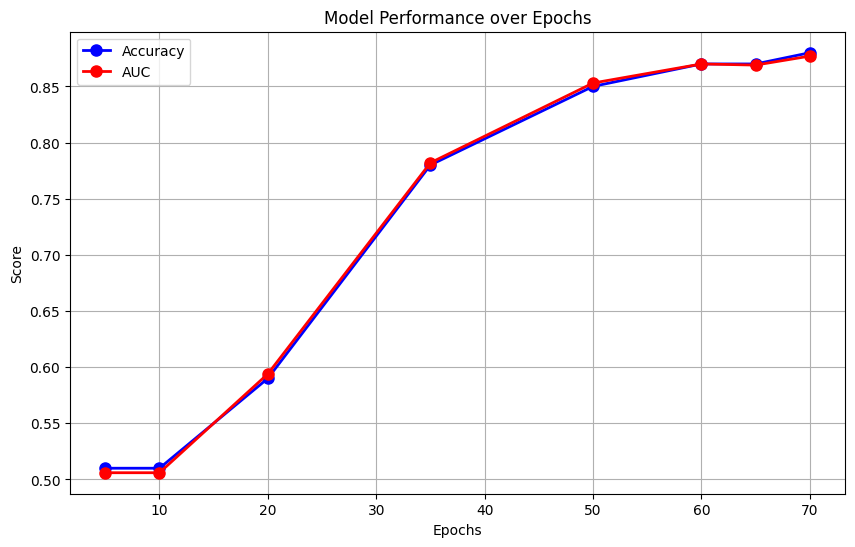

In [ ]:
import matplotlib.pyplot as plt

epochs = [5, 10, 20, 35, 50, 60, 65, 70]
accuracy = [0.51, 0.51, 0.59, 0.78, 0.85, 0.87, 0.87, 0.88]
auc = [0.506, 0.506, 0.594, 0.782, 0.853, 0.870, 0.869, 0.877]

plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label="Accuracy", marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, auc, label="AUC", marker='o', color='r', linestyle='-', linewidth=2, markersize=8)

plt.title("Model Performance over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

plt.grid(True)
plt.show()


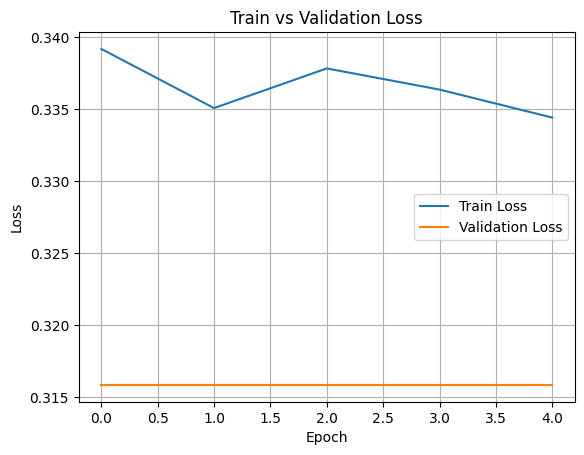

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluate BERT (Original + NLPaug)

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.concat([df_small, df_nlpaug])
texts = df['review'].astype(str).tolist()
labels = df['label'].values

def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors='pt')

encoded = tokenize_data(texts)
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']
labels_tensor = torch.tensor(labels)

train_idx, temp_idx = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=0)

test_dataset = TensorDataset(input_ids[test_idx], attention_mask[test_idx], labels_tensor[test_idx])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_paths = {
    12: "/content/drive/MyDrive/bert_model/seed/bert_seed12-50.pt",
    44: "/content/drive/MyDrive/bert_model/seed/bert_seed44-50.pt",
    127: "/content/drive/MyDrive/bert_model/seed/bert_seed127-50.pt"
}

results = {}

for seed, path in model_paths.items():
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids_b = batch[0].to(device)
            attention_mask_b = batch[1].to(device)
            labels_b = batch[2].to(device)

            outputs = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels_b.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    results[seed] = {'Accuracy': acc, 'F1': f1, 'AUC': auc}

# Results Table
df_results = pd.DataFrame(results).T
df_results.index.name = "Seed"
df_results.reset_index(inplace=True)


In [ ]:
df_results

,Seed,Accuracy,F1,AUC
0,12,0.995,0.994955,0.997900
1,44,0.997,0.996991,0.998996
2,127,0.993,0.992965,0.995308


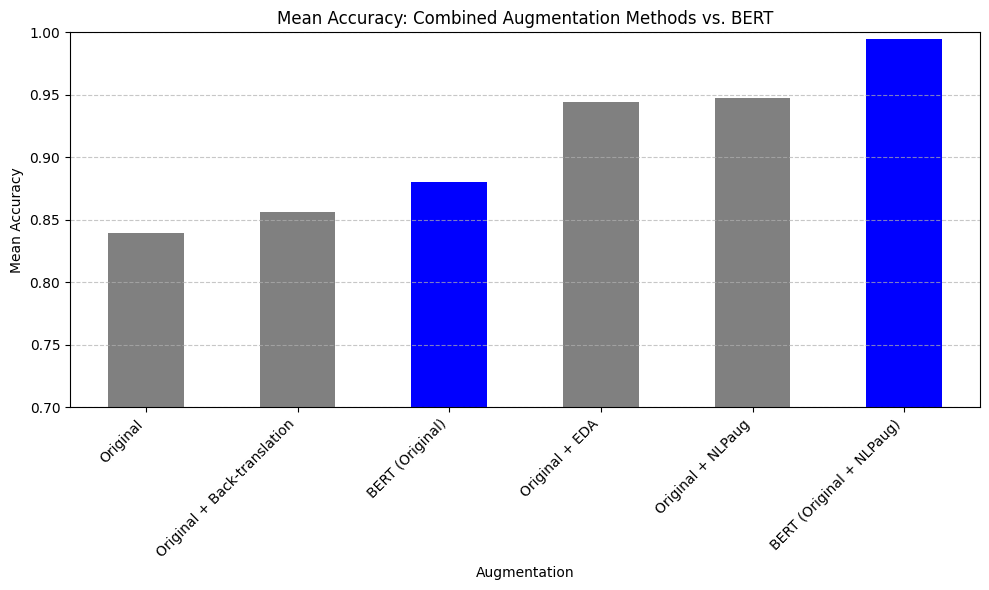

In [ ]:
combined_methods = results_df[results_df['Augmentation'].str.startswith('Original')]

mean_acc_combined = combined_methods.groupby('Augmentation')['Accuracy'].mean()

bert_mean_acc = 0.995
bert_acc = 0.88
mean_acc_combined['BERT (Original + NLPaug)'] = bert_mean_acc
mean_acc_combined['BERT (Original)'] = bert_acc

mean_acc_combined = mean_acc_combined.sort_values()

colors = ['blue' if 'BERT' in str(key) else 'gray' for key in mean_acc_combined.index]

# Plot
plt.figure(figsize=(10, 6))
mean_acc_combined.plot(kind='bar', color=colors)

plt.title('Mean Accuracy: Combined Augmentation Methods vs. BERT')
plt.ylabel('Mean Accuracy')
plt.ylim(0.7, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("combined_augmentation_vs_bert_accuracy.png")
plt.show()
